# Finding regular equivalence classes with blockmodelling

In [2]:
libs <- c(
  "dplyr",
  "tidyr",
  "forcats",
  "arrow",
  "igraph",
  "blockmodeling",
  "ggplot2",
  "svglite"
)
new.packages <- libs[!(libs %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
invisible(lapply(libs, library, character.only = TRUE))

Read graphs

In [10]:
types = c('replies', 'votes', 'follows')
gs = list()
n = 253
for (t in types) {
  gs[[t]] = read_graph(paste0('graphs/',t,'-',n,'.graphml'), format = 'graphml')
}

## Perform blockmodelling on the three graphs.

Takes a long time. Not necessary to run if .rds result files already available.

In [ ]:
bm = list()
# appr = 'bin'
appr = 'val'
for (x in types) {
  M <- as_adjacency_matrix(gs[[x]], sparse = FALSE)
  results = list()
  for (k in 3:8) {
    res <- optRandomParC(M = M, k = k, rep = 1000,
        approach = appr, blocks = c('nul', 'com', 'reg'), nCores = 0)
    print(err(res))
    results[[k]] = res
  }
  # saveRDS(results, file=paste0('results/bm/', x, '-', n, '.rds'))
  bm[[x]] = results
}
saveRDS(bm, file=paste0('results/bm/', 'bm-all-', n, '-', appr, '.rds'))
for (r in results){
  print(err(r))
}

Loading required namespace: doParallel

Warning message in optRandomParC(M = M, k = k, rep = 1000, approach = appr, blocks = c("nul", :
“useLB not set and now set to TRUE. parLapplyLB will be used. Results will not be reproducible.”


## Optimal group assignments based on blockmodelling results

### Inspect groups found by blockmodelling.

Inspect permuted matrices

In [7]:
appr = 'bin'
# appr = 'val'
res = readRDS(paste0('results/bm/', 'bm-', n, '-', appr, '.rds'))

Print adjacency matrices

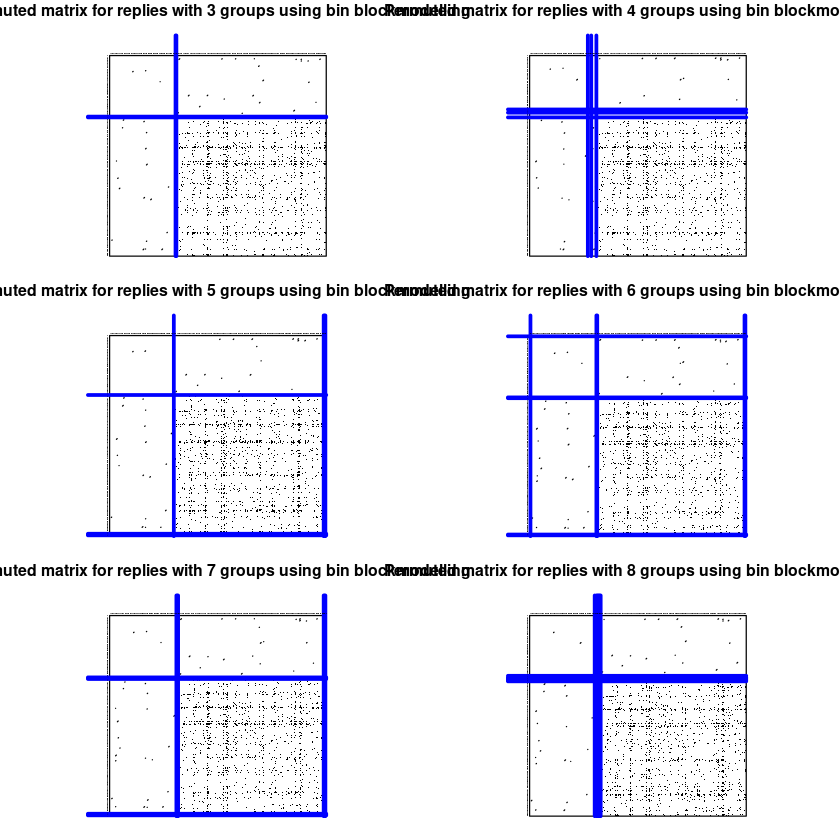

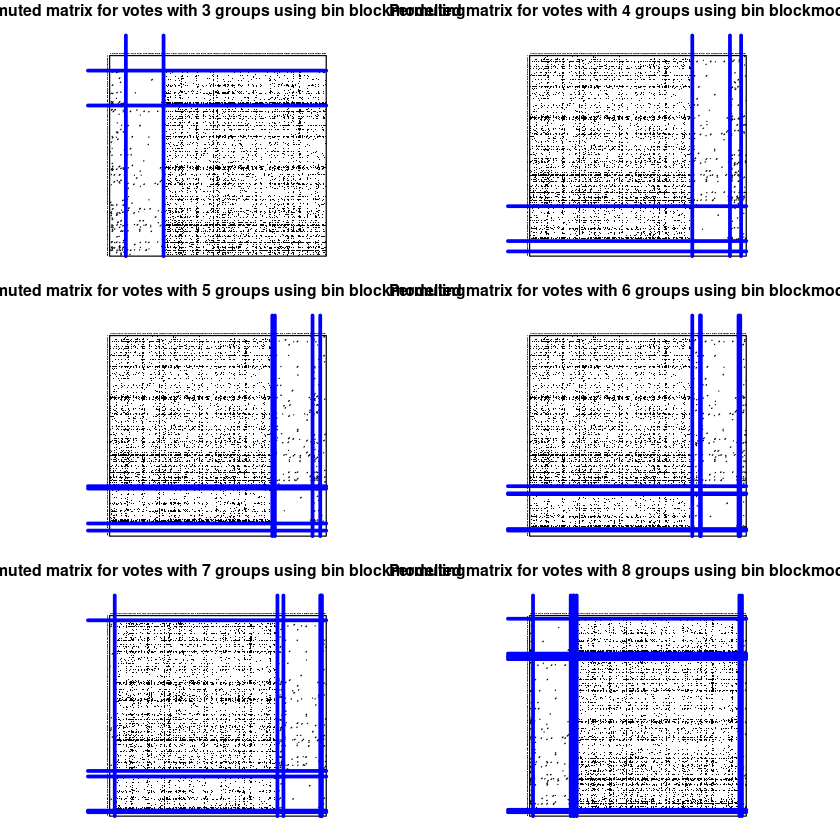

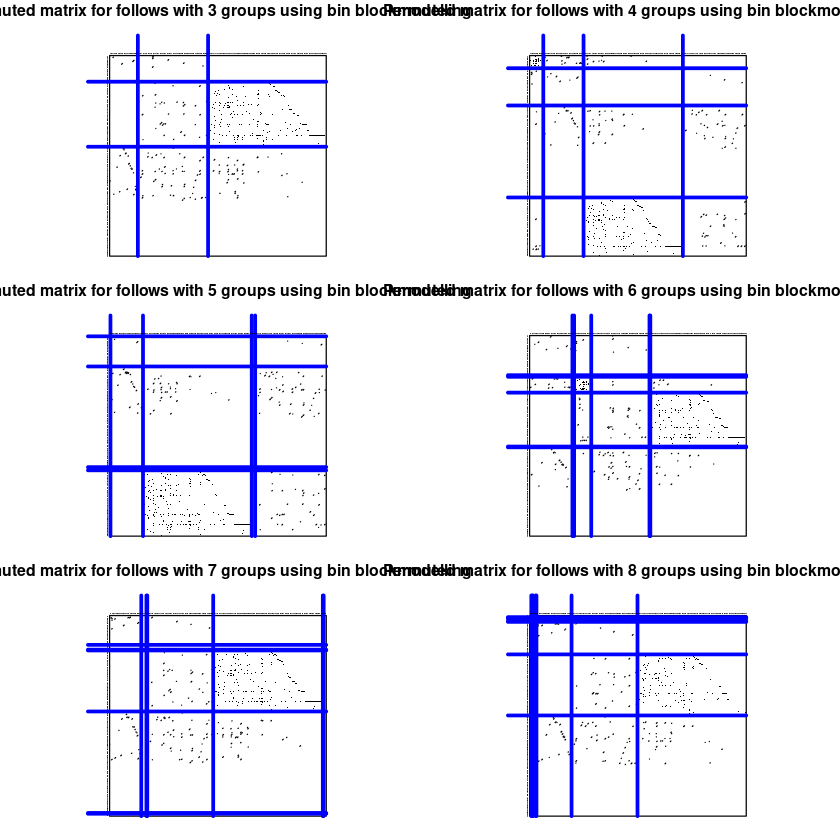

In [17]:
for (x in types) {
  par(mfrow = c(3, 2))
  for (k in 3:8) {
    # png(paste0('results/bm/adjmat-', n, '-', x,'-',k, '-', appr, '.png'), width = 800, height = 800)
    plot(res[[x]][[k]], main = paste('Permuted matrix for', x, 'with', k, 'groups using', appr, 'blockmodelling'),
      mar = c(1, 2, 3, 1), title.line = 2)
    dens = funByBlocks(res[[x]][[k]])
    dens[is.nan(dens)] <- 0
    # plotMat(dens)
    # dev.off()
  }
}

### Decide optimal number of groups

Inspect number of regular equivalence inconsistencies over different numbers of groups.

Warning message in min(res$err):
“no non-missing arguments to min; returning Inf”
Warning message in min(res$err):
“no non-missing arguments to min; returning Inf”


Warning message in min(res$err):
“no non-missing arguments to min; returning Inf”
Warning message in min(res$err):
“no non-missing arguments to min; returning Inf”


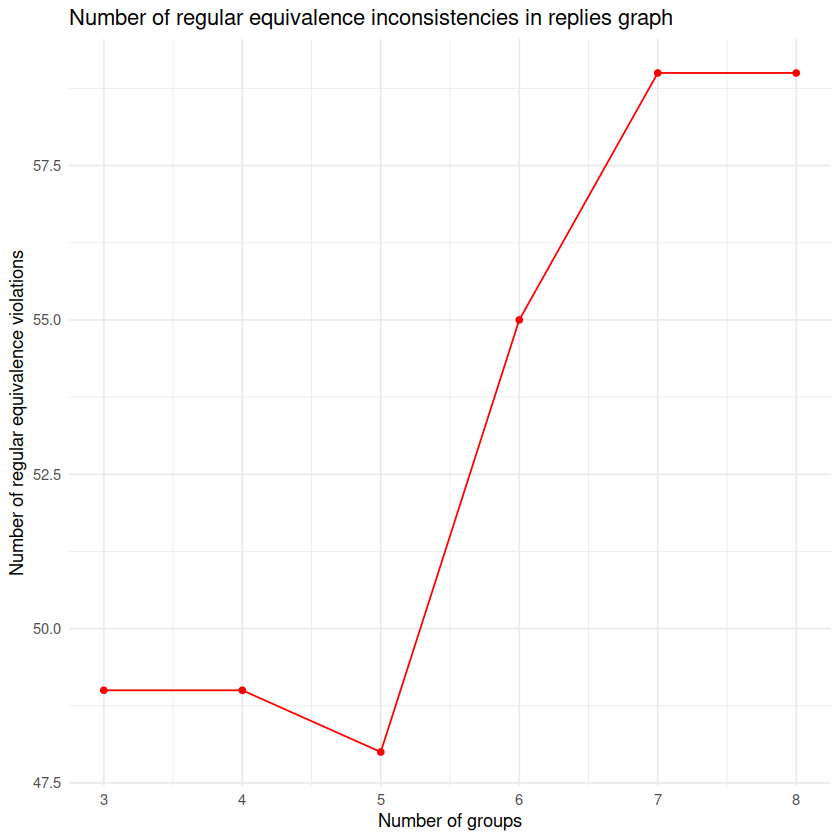

Warning message in min(res$err):
“no non-missing arguments to min; returning Inf”
Warning message in min(res$err):
“no non-missing arguments to min; returning Inf”


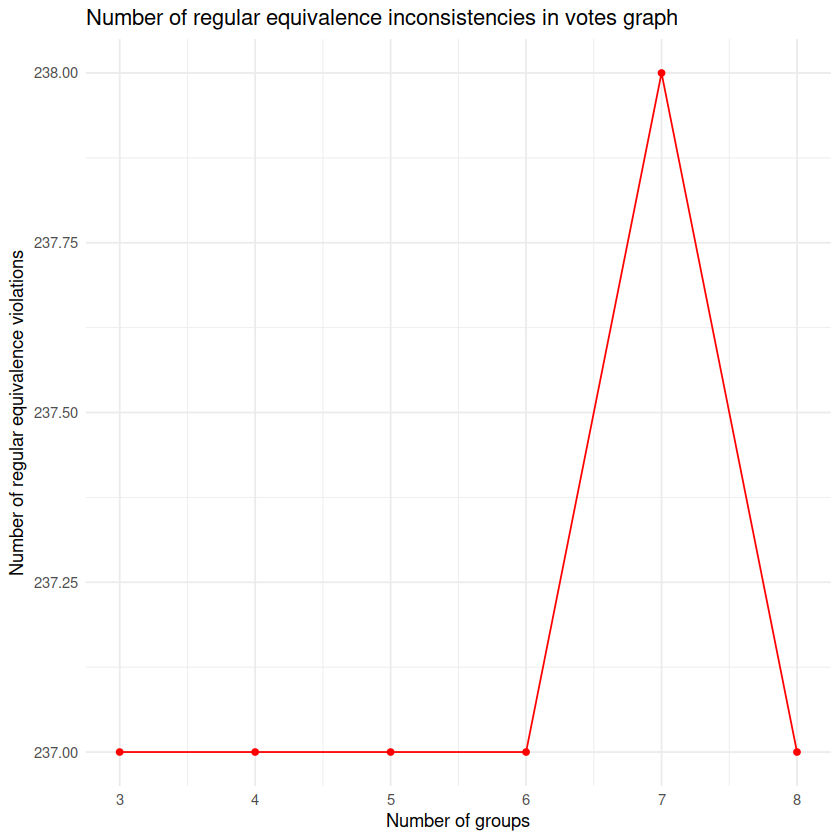

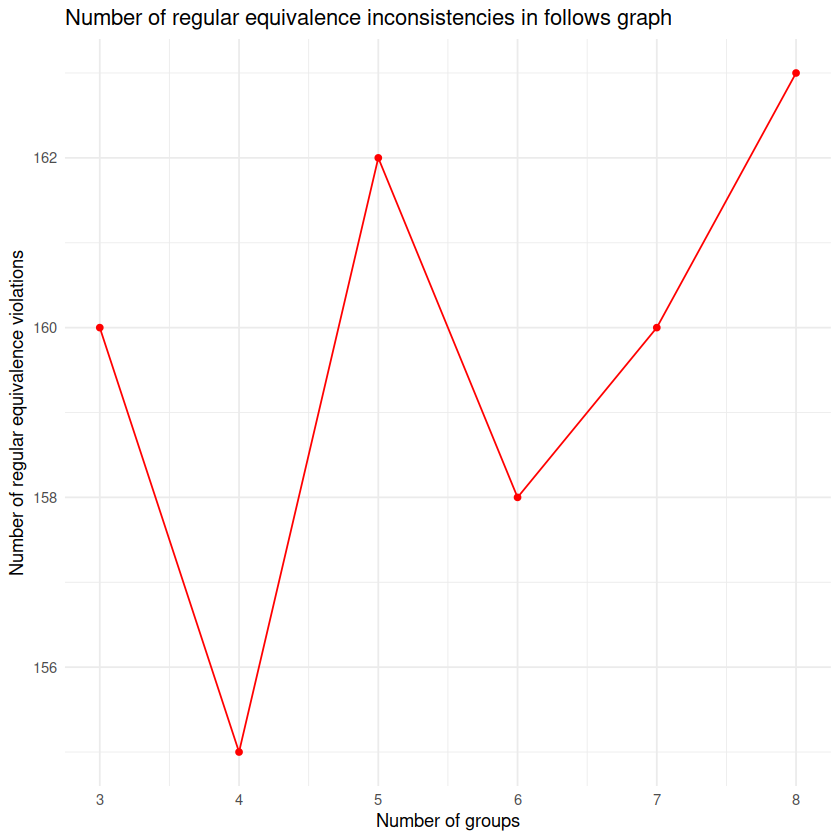

In [14]:
errs = list()

for (t in types) {
  err = sapply(res[[t]], err)[3:8]
  errs[[t]] = err
  p = ggplot(mapping =aes(x = 3:8, y = err)) +
    geom_line(color = 'red') +
    geom_point(color = 'red') +
    labs(
      title = paste('Number of regular equivalence inconsistencies in', t, 'graph'),
      x = 'Number of groups',
      y = 'Number of regular equivalence violations'
    ) +
    theme_minimal()
  print(p)
  # ggsave(paste0('results/bm/incons-', n, '-', t, '.svg'))
}

Inspect overall inconsistency rates in all 3 graphs

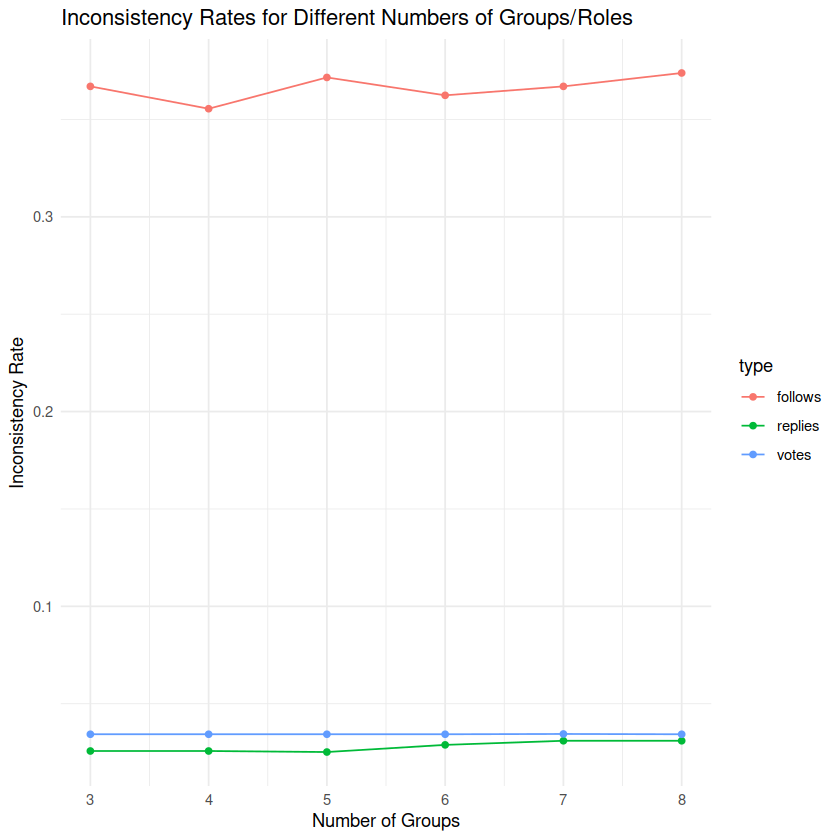

In [15]:
errrate_replies = errs[['replies']] / ecount(gs[['replies']])
errrate_votes = errs[['votes']] / ecount(gs[['votes']])
errrate_follows = errs[['follows']] / ecount(gs[['follows']])

errs <- data.frame(
  groups = rep(3:8, 3),
  error_rate = c(errrate_replies, errrate_votes, errrate_follows) ,
  type = rep(types, each = 6)
)

ggplot(errs, aes(x = groups, y = error_rate, color = type)) +
  geom_line() +
  geom_point() +
  labs(title = "Inconsistency Rates for Different Numbers of Groups/Roles",
       x = "Number of Groups",
       y = "Inconsistency Rate") +
  theme_minimal()

# ggsave(paste0('results/bm/incons-', n, '.svg'))

We choose the partitioning with lower inconsistencies, and lower number of groups with nicer partitioning based on permuted adjacency matrix for easier interpretation. Therefore, we choose 3 groups for replies, 4 for votes, 3 for follows.

We then export the assigned group membership for further analysis

In [16]:
# set number of groups in each graph based on findings 
k = list(replies = 3, votes = 3, follows = 4)

groups = list(3)

for (type in types) {
  clus = data.frame(
    name = V(gs[[type]])$name,
    type = clu(res[[type]][[k[[type]]]])
  )
  names(clus) = c('name', paste0('group_', type))
  groups[[type]] = clus
}
membership = groups[['replies']] %>%
  inner_join(groups[['votes']], by = 'name') %>%
  inner_join(groups[['follows']], by = 'name') %>%
  unite(group,contains('group_'), remove=FALSE)
head(membership)
# write.csv(membership, paste0('results/bm/membership-', n, '.csv'), row.names = FALSE)

,name,group,group_replies,group_votes,group_follows
,<chr>,<chr>,<int>,<int>,<int>
1,6007,1_2_2,1,2,2
2,14285,1_2_4,1,2,4
3,18786,3_3_4,3,3,4
4,24561,1_3_2,1,3,2
5,26146,3_3_3,3,3,3
6,28707,3_2_3,3,2,3
